In [1]:
import pandas as pd
import numpy as np
import datetime as datetime
from datetime import timedelta
import os
path = "F:\\OneDrive - WHISK SOFTWARE PVT. LTD\\Sequence by Segment\\"
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingRegressor
from pylab import rcParams
np.set_printoptions(precision=3)

## Read Search Terms and Product ids

In [2]:
search_term_product_id = pd.read_excel("search_term_product_id_copy.xlsx")
search_term_product_id.head()

,Search_Terms,Product_ids
0,MICHAEL KORS HANDBAGS,"5611119,5611118,5611117,5611116,5611104,561110..."
1,POLO RALPH LAUREN MEN,"6119017,6058877,6039812,6039779,6039770,603976..."
2,WOMENS BOOTS,"6132689,6119374,6114123,6114071,6108292,610798..."
3,COACH HANDBAGS,"5735229,5730249,5730246,5729228,5729227,561735..."
4,MICHAEL KORS WATCHES,"5814368,5814109,5814108,5814107,5814105,581410..."


## Create list of unique Product ids

In [4]:
products = []
for row in search_term_product_id.Product_ids:
    products.extend(row.split(","))
    
prod_list=list(set(products))

In [14]:
products

['5611119',
 '5611118',
 '5611117',
 '5611116',
 '5611104',
 '5611102',
 '5611097',
 '5611095',
 '5611094',
 '5611091',
 '5611087',
 '5611082',
 '5611079',
 '5611073',
 '5611069',
 '5611068',
 '5611060',
 '5611048',
 '5611044',
 '5611042',
 '5611040',
 '5611035',
 '5611032',
 '5611031',
 '5611017',
 '5611016',
 '5611014',
 '5611013',
 '5611012',
 '5611008',
 '5611006',
 '5611003',
 '5610999',
 '5607351',
 '5519660',
 '5519657',
 '5519656',
 '5503952',
 '5444703',
 '5374462',
 '5374451',
 '5374439',
 '5374421',
 '5374413',
 '5357769',
 '5324677',
 '5295864',
 '5295863',
 '5295862',
 '5295861',
 '5295295',
 '5251265',
 '5251252',
 '5225297',
 '5225296',
 '5225293',
 '5225289',
 '5225286',
 '5225285',
 '5225284',
 '5225283',
 '5225279',
 '5225278',
 '5225270',
 '5225269',
 '5225268',
 '5225267',
 '5225266',
 '5225250',
 '5225249',
 '5225157',
 '5201917',
 '5201912',
 '5201911',
 '5201910',
 '5201909',
 '5201904',
 '5201902',
 '5201901',
 '5201900',
 '5201899',
 '5201898',
 '5201896',
 '52

In [4]:
products = []
for row in search_term_product_id.Product_ids:
    products.extend(row.split(","))

prod_list= list(set(products))

##  Read User Data with Segments

In [51]:
user_data = pd.read_csv("USER_DATA_copy.csv")
user_data.WEB_PROD_ID  = user_data.WEB_PROD_ID.apply(lambda x: int(x.replace(",","")))
user_data.SALES  = user_data.SALES.apply(lambda x: float(x.replace(",","")))
user_data.info()

AttributeError: 'DataFrame' object has no attribute 'WEB_PROD_ID'

In [55]:
user_data[(user_data.WEB_PROD_ID==2912438) & (user_data.SEGMENT == 3)].sort_values(by="ORIG_ORD_DT")

,WEB_PROD_ID,USR_ID,ORIG_ORD_DT,SALES,SRC_SYS_KEY,DOB_DT,SEGMENT


In [56]:
user_data_4 = user_data[user_data.SEGMENT==4]
#user_data_4.pivot_table(index='WEB_PROD_ID',columns='ORIG_ORD_DT',values='SALES',aggfunc=np.sum)

## Functions 

In [57]:
def clean_data(data):
    data.fillna(0,inplace=True)
    data.drop(['WEB_PROD_ID_x','WEB_PROD_ID_y','WEB_PROD_ID'],axis=1,inplace=True)
    #data=data.dropna()
    data['NEWNESS'] = np.nan
    data.loc[data.PRODUCT_AGE>22,'NEWNESS'] = "OLD"
    data.loc[(data.PRODUCT_AGE>=8) & (data.PRODUCT_AGE<=21),'NEWNESS'] = "NEWER"
    data.loc[(data.PRODUCT_AGE>=1) & (data.PRODUCT_AGE<=7),'NEWNESS'] = "NEWEST"
    
    data['TOTAL_REVIEWS'] = data.BV_NUM_OF_REVIEWS*data.BV_RATING

    categorical_features = ['CLEARANCE_PRICE_TYPE','LPOS_PRICE_TYPE','REBATES','SALE_PRICE_TYPE_CURR','SALE_PRICE_TYPE_NEXT','NEWNESS','ON_PROMOTION',
                           'BV_RATING_BUCKET']
    data = pd.get_dummies(data,columns=categorical_features)
    for col in data.columns:
        if isinstance(col, tuple):
            data.rename(columns={col:col[0]+"_"+str(col[1])},inplace=True)
    return data

def user_data_merge(rdpp_date,user_data,read):
    rdpp_data = pd.read_csv(path+"rdpp_Data\\rdpp_data_"+rdpp_date.strftime("%Y-%m-%d")+".csv")
    user_data.ORIG_ORD_DT = pd.to_datetime(user_data.ORIG_ORD_DT)
    #user_data.loc[user_data.SEGMENT==1,'SEGMENT'] = 2
    
    prev_date_1 = rdpp_date - timedelta(5)
    prev_date_2 = rdpp_date - timedelta(1)
    
    temp = user_data[(user_data['ORIG_ORD_DT'] >= prev_date_1) &  (user_data['ORIG_ORD_DT'] <= rdpp_date)]
    temp = temp.pivot_table(index='WEB_PROD_ID',columns='SEGMENT',values='SALES',aggfunc=np.sum).reset_index(None)
    rdpp_data = rdpp_data.merge(temp, left_on='PRODUCT_ID',right_on='WEB_PROD_ID',how='inner')
    for index,col in enumerate(rdpp_data.columns):
        if col in [1.0,2.0,3.0,4.0,5.0,6.0,7.0]:
            rdpp_data.rename(columns={col:'SALES_HIST_SEG_'+str(int(col))},inplace=True )
            
    temp = user_data[user_data['ORIG_ORD_DT'] == rdpp_date]
    temp = temp.pivot_table(index='WEB_PROD_ID',columns='SEGMENT',values='SALES',aggfunc=np.sum).reset_index(None)
    rdpp_data = rdpp_data.merge(temp, left_on='PRODUCT_ID',right_on='WEB_PROD_ID',how='left')
    for index,col in enumerate(rdpp_data.columns):
        if col in [1.0,2.0,3.0,4.0,5.0,6.0,7.0]:
            rdpp_data.rename(columns={col:'SALES_CURR_SEG_'+str(int(col))},inplace=True )
            
    next_date = rdpp_date + timedelta(1)
    temp = user_data[user_data['ORIG_ORD_DT'] == next_date]
    temp = temp.pivot_table(index='WEB_PROD_ID',columns='SEGMENT',values='SALES',aggfunc=np.sum).reset_index(None)
    rdpp_data = rdpp_data.merge(temp, left_on='PRODUCT_ID',right_on='WEB_PROD_ID',how='left')
    for index,col in enumerate(rdpp_data.columns):
        if col in [1.0,2.0,3.0,4.0,5.0,6.0,7.0]:
            rdpp_data.rename(columns={col:'SALES_NEXT_SEG_'+str(int(col))},inplace=True )
    
    rdpp_data.fillna(0,inplace=True)
    if read:
        views = pd.read_csv(path+"Views_Data\\VIEWS_"+rdpp_date.strftime("%Y-%m-%d")+".csv")
    else:
        views = get_prod_views(rdpp_date.strftime("%Y%m%d"))
        views.PRODUCT_ID = views.PRODUCT_ID.astype(int)
        views.to_csv("VIEWS_"+rdpp_date.strftime("%Y-%m-%d")+".csv",index=False)
    
    rdpp_data = rdpp_data.merge(views,left_on='PRODUCT_ID',right_on='PRODUCT_ID',how='inner')
    rdpp_data.rename(columns = {'SALE_PRICE_TYPE':'SALE_PRICE_TYPE_CURR'},inplace=True)
    rdpp_data_next = pd.read_csv(path+"rdpp_Data\\rdpp_data_"+next_date.strftime("%Y-%m-%d")+".csv")
    rdpp_data = rdpp_data.merge(rdpp_data_next[['PRODUCT_ID','SALE_PRICE_TYPE']],left_on='PRODUCT_ID',right_on='PRODUCT_ID',how='inner')
    rdpp_data.rename(columns = {'SALE_PRICE_TYPE':'SALE_PRICE_TYPE_NEXT'},inplace=True) 
            
    return clean_data(rdpp_data)

def modelfit(alg, dtrain, predictors, target, performCV=True, FeatureImportance=True, cv_folds=5,save_model=False,modelFileName='Final_GBM.sav'):
    alg.fit(dtrain[predictors], dtrain[target])
    dtrain_predictions = alg.predict(dtrain[predictors])
    
    if performCV:
        cv_score = cross_val_score(alg, dtrain[predictors], dtrain[target], cv=cv_folds, scoring='neg_mean_squared_error')
    print("\nModel Report")
    print ("RMSE : %.4g" % np.sqrt(mean_squared_error(dtrain[target].values, dtrain_predictions)))
    
    if performCV:
        print ("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
            
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
        
    if save_model:
        filename = modelFileName
        pickle.dump(alg, open(filename, 'wb'))
    return alg

def print_test_results(y_test, y_pred):
    print("Correlation : ", np.corrcoef(y_test, y_pred))
    print( "Root mean squared error : ", np.sqrt(mean_squared_error(y_test, y_pred)))
    print( "R2 score (coef determination) : ", r2_score(y_test, y_pred))
    
def rank_plot(data_test,pred_var,actual_var,term):
    data_test.sort_values(by=pred_var,ascending=False,inplace=True)
    data_test['PREDICTED_RANK'] = range(1,len(data_test)+1)
    data_test.sort_values(by=actual_var,ascending=False,inplace=True)
    data_test['ACTUAL_RANK'] = range(1,len(data_test)+1)

    data = data_test[['PRODUCT_ID','ACTUAL_RANK','PREDICTED_RANK']].head(15)
    data.index = data['PRODUCT_ID']
    del data['PRODUCT_ID']
    data.plot(kind='bar',title=pred_var + " " + term)
    return data_test[['PRODUCT_ID','ACTUAL_RANK','PREDICTED_RANK']].sort_values(by="PREDICTED_RANK")

In [ ]:
whole_df.to_csv("SheetMetal_PREDICTED.csv",index=False)

## Set Dates for Train and Test data

In [58]:
rdpp_date_train = datetime.date.today()-timedelta(38)
print ("training date..." + rdpp_date_train.strftime("%Y-%m-%d"))
rdpp_date_test = datetime.date.today()-timedelta(37)
print ("test date..." + str(rdpp_date_test.strftime("%Y-%m-%d")))

training date...2018-02-01
test date...2018-02-02


## Create Train and Test data

In [86]:
row = 0
prod_row = search_term_product_id.iloc[row,1].split(",")
print( "training date..." + rdpp_date_train.strftime("%Y-%m-%d"))
data_train = user_data_merge(rdpp_date_train,user_data,read=True)
data_train = data_train[data_train.PRODUCT_ID.isin(prod_list)]
data_train = data_train[data_train.CS_AVAILABLE_QTY_ON_HAND>0]

print ("test date..." + str(rdpp_date_test.strftime("%Y-%m-%d")))
data_test = user_data_merge(rdpp_date_test,user_data,read=True)
data_test = data_test[data_test.PRODUCT_ID.isin(prod_list)]
#data_test = data_test[data_test.CS_AVAILABLE_QTY_ON_HAND>0]

training date...2018-02-01


FileNotFoundError: File b'F:\\OneDrive - WHISK SOFTWARE PVT. LTD\\Sequence by Segment\\rdpp_Data\\rdpp_data_2018-02-01.csv' does not exist

In [69]:
user_data_merge(rdpp_date_train,user_data,read=True)

FileNotFoundError: File b'F:\\OneDrive - WHISK SOFTWARE PVT. LTD\\Sequence by Segment\\rdpp_Data\\rdpp_data_2018-02-01.csv' does not exist

## Traing the model 


Model Report
RMSE : 1.011
CV Score : Mean - -24.81846 | Std - 8.285134 | Min - -33.1036 | Max - -16.53333
('Correlation : ', array([[ 1.   ,  0.017],
       [ 0.017,  1.   ]]))
('Root mean squared error : ', 2.5792003275397404)
('R2 score (coef determination) : ', -0.30475239671679821)


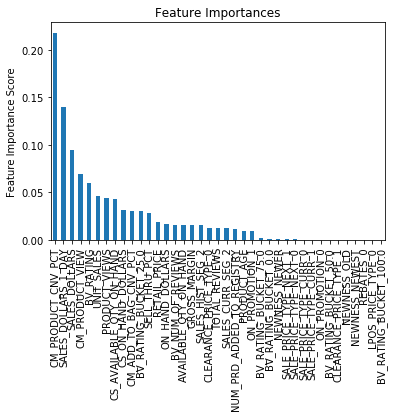

In [77]:
ID =['PRODUCT_ID']
target = ['SALES_NEXT_SEG_2']
predictors = ['AVAILABLE_QTY_ON_HAND', 'BV_NUM_OF_REVIEWS','BV_RATING', 'CM_ADD_TO_BAG_CNV_PCT', 'CM_PRODUCT_CNV_PCT',
       'CM_PRODUCT_VIEW', 'CS_AVAILABLE_QTY_ON_HAND', 'CS_ON_HAND_DOLLARS','GROSS_MARGIN', 'NUM_PRD_ADDED_TO_REGISTRY', 'ON_HAND_DOLLARS',
       'PRODUCT_AGE', 'RETAIL_PRICE', 'SALES_DOLLARS','SALES_DOLLARS_1_DAY', 'SELL_THRU_PCT', 'UNIT_SALES',
       'SALES_HIST_SEG_2', 
       'SALES_CURR_SEG_2', 
       'PRODUCT_VIEWS', 'TOTAL_REVIEWS', 'CLEARANCE_PRICE_TYPE_0', 'CLEARANCE_PRICE_TYPE_1', 'LPOS_PRICE_TYPE_0', 'REBATES_0',
       'SALE_PRICE_TYPE_CURR_0', 'SALE_PRICE_TYPE_CURR_1','SALE_PRICE_TYPE_NEXT_0', 'SALE_PRICE_TYPE_NEXT_1', 'NEWNESS_NEWER',
       'NEWNESS_NEWEST', 'NEWNESS_OLD', 'ON_PROMOTION_0', 'ON_PROMOTION_1', 'BV_RATING_BUCKET_0.0', 'BV_RATING_BUCKET_25.0',
       'BV_RATING_BUCKET_50.0', 'BV_RATING_BUCKET_75.0', 'BV_RATING_BUCKET_100.0']


for tgt in target:
    gbm0 = GradientBoostingRegressor(random_state=100)
    clf = modelfit(gbm0, data_train, predictors,tgt,performCV=True,printFeatureImportance=True,cv_folds=2,
             save_model=False,modelFileName='model.sav')

    data_test['PREDICTED_GBM'] = clf.predict(data_test[predictors])
    print_test_results(data_test.SALES_NEXT_SEG_2, data_test['PREDICTED_GBM'])
    data_test.rename(columns={'PREDICTED_GBM':"PREDICTED_SEG" + str(tgt.split("_")[-1])},inplace=True)

In [83]:
data_test[data_test.PRODUCT_ID==4753278].T

,27707
PRODUCT_ID,4.753278e+06
AVAILABLE_QTY_ON_HAND,1.400000e+01
BV_NUM_OF_REVIEWS,6.000000e+01
BV_RATING,3.830000e+00
CM_ADD_TO_BAG_CNV_PCT,2.129900e-01
CM_PRODUCT_CNV_PCT,7.334000e-02
CM_PRODUCT_VIEW,3.213700e+04
CS_AVAILABLE_QTY_ON_HAND,1.135000e+03
CS_ON_HAND_DOLLARS,2.269886e+05
GROSS_MARGIN,4.731000e+01


In [81]:
data_test[['PRODUCT_ID','SALES_HIST_SEG_2','SALES_CURR_SEG_2','SALES_NEXT_SEG_2','PREDICTED_SEG2']].sort_values(by="SALES_NEXT_SEG_2",ascending=False)

,PRODUCT_ID,SALES_HIST_SEG_2,SALES_CURR_SEG_2,SALES_NEXT_SEG_2,PREDICTED_SEG2
27707,4753278,0.00,0.00,82.50,0.215718
28302,4763685,32.30,0.00,63.50,0.878621
2198,468732,0.00,0.00,60.00,0.005566
44760,5118279,0.00,0.00,58.96,3.891391
10274,2361315,0.00,0.00,57.00,0.046147
49379,5225115,0.00,0.00,53.16,0.012174
24192,4614711,0.00,0.00,52.00,0.137651
35203,4877976,51.04,0.00,51.04,4.155411
33201,4852538,0.00,0.00,47.50,0.021600
62570,5790943,0.00,0.00,42.50,0.657528


In [20]:
data_test[data_test.AVAILABLE_QTY_ON_HAND==0][['CS_AVAILABLE_QTY_ON_HAND','AVAILABLE_QTY_ON_HAND','RETAIL_PRICE','SALES_CURR_SEG_2','SALES_NEXT_SEG_2']]

,CS_AVAILABLE_QTY_ON_HAND,AVAILABLE_QTY_ON_HAND,RETAIL_PRICE,SALES_CURR_SEG_2,SALES_NEXT_SEG_2
2551,422.0,0.0,100.00,0.0,0.0
2552,422.0,0.0,120.00,0.0,0.0
4622,29348.0,0.0,25.00,0.0,0.0
4978,422.0,0.0,200.00,0.0,0.0
6188,198.0,0.0,46.99,0.0,0.0
6989,5912.0,0.0,39.98,0.0,0.0
9048,0.0,0.0,179.00,0.0,0.0
10135,422.0,0.0,30.00,0.0,0.0
11758,0.0,0.0,139.00,0.0,0.0
11759,0.0,0.0,139.00,0.0,0.0


C:\Users\Admin\Anaconda2\lib\site-packages\ipykernel\__main__.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Admin\Anaconda2\lib\site-packages\ipykernel\__main__.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Admin\Anaconda2\lib\site-packages\ipykernel\__main__.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Admin\Anaconda2\lib\site-packages\ipykernel\__main__.py:97: SettingWithCopyWarning: 


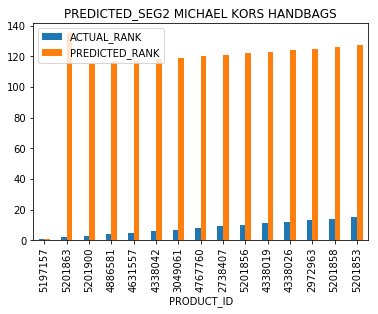

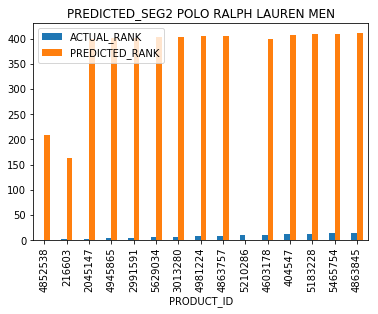

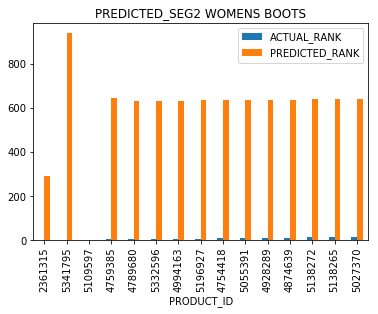

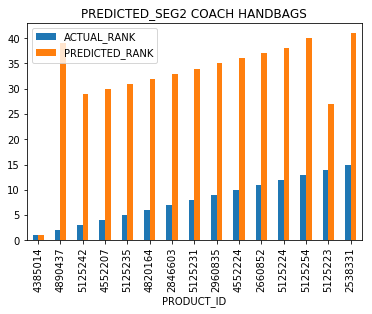

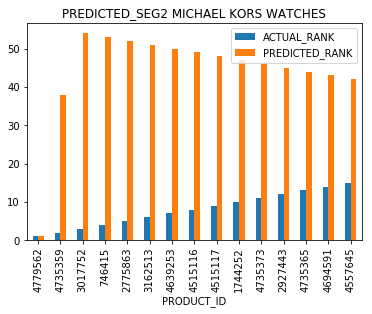

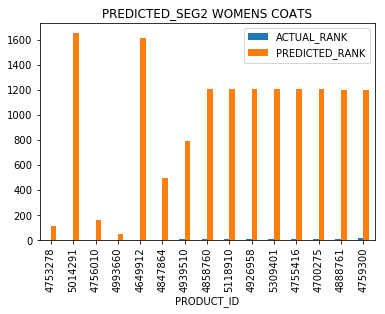

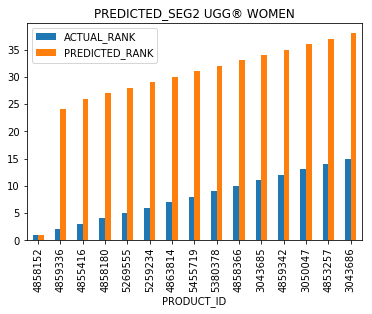

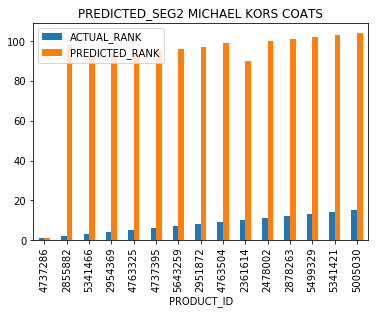

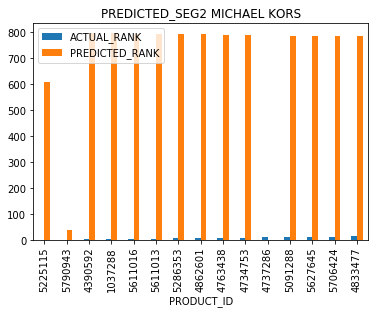

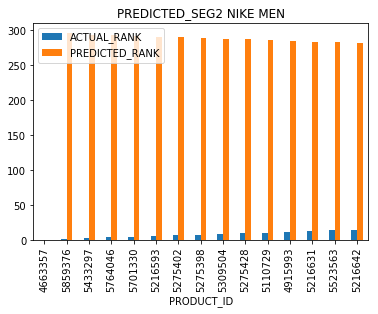

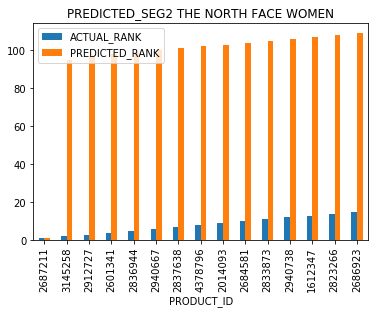

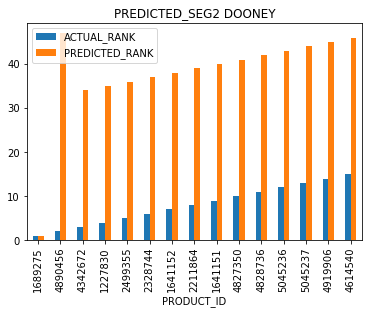

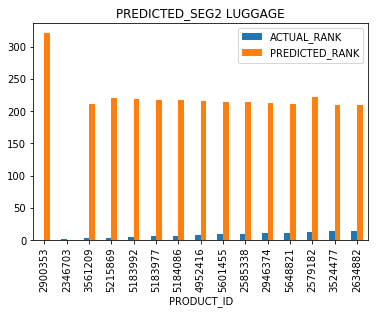

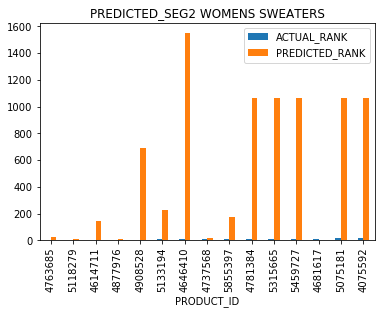

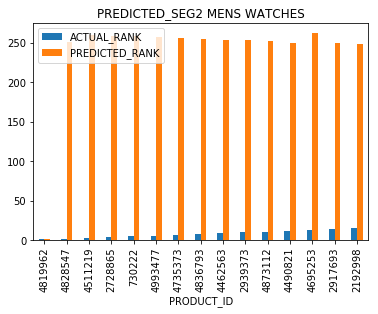

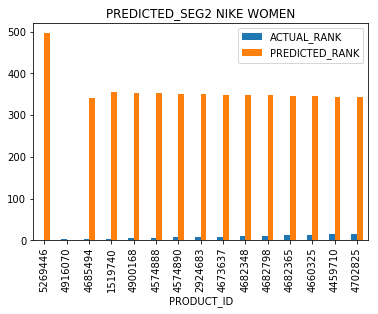

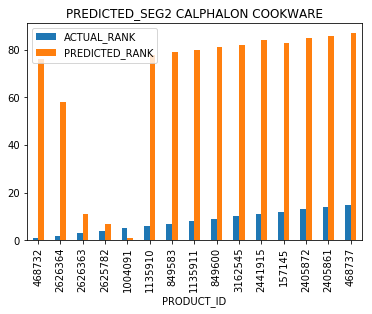

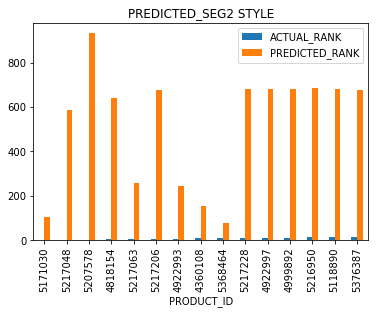

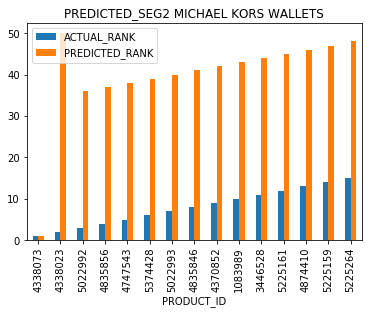

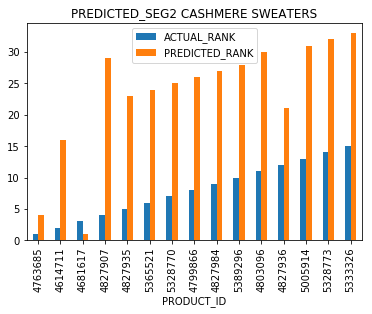

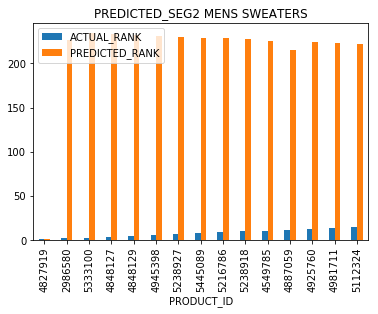

In [79]:
df = pd.DataFrame(columns=['search_term','product_ids'])
rows = range(21)
for row in rows:
    temp = data_test[data_test.PRODUCT_ID.isin(search_term_product_id.iloc[row,1].split(","))]
    pred_var = 'PREDICTED_SEG2'
    actual_var = 'SALES_NEXT_SEG_2'
    search_term = search_term_product_id.iloc[row,0]
    x = rank_plot(temp,pred_var,actual_var,search_term)
    df = df.append({"search_term":search_term,"product_ids":str(list(x['PRODUCT_ID'])).replace("[","").replace("]","")},
              ignore_index=True)
        

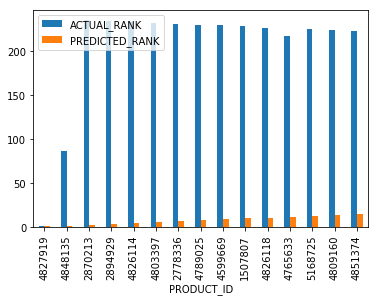

In [50]:
x.index = x['PRODUCT_ID']
del x['PRODUCT_ID']
x[:15].plot(kind='bar')

In [80]:
df.to_csv("search_term_results_seg_2.csv",index=False,encoding='utf-8')